# Model Reduction Exercise 2

In this report, we aim to identify the most parsimonious model for three different datasets: *Splityield*, *Happiness Score* and *House Prices*. This we do to find the best model with the optimal balance between simplicity and explanatory power. We will aplly selection techniques such as feature selection based on correlation and AIC and performance evaluation metricts to find the moste efficient model for each dataset. 

### Import Libaries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn import metrics
from scipy.stats import chi2_contingency
from itertools import combinations
from statsmodels.formula.api import mixedlm

## 1. Splityield

In [2]:
df = pd.read_csv('data/splityield.txt', sep="\\t", engine="python")

# Display the first few rows
df

,yield,block,irrigation,density,fertilizer
0,90,A,control,low,N
1,95,A,control,low,P
2,107,A,control,low,NP
3,92,A,control,medium,N
4,89,A,control,medium,P
...,...,...,...,...,...
67,131,D,irrigated,medium,P
68,126,D,irrigated,medium,NP
69,116,D,irrigated,high,N
70,136,D,irrigated,high,P


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   yield       72 non-null     int64 
 1   block       72 non-null     object
 2   irrigation  72 non-null     object
 3   density     72 non-null     object
 4   fertilizer  72 non-null     object
dtypes: int64(1), object(4)
memory usage: 2.9+ KB


### 1.1 Heatmap

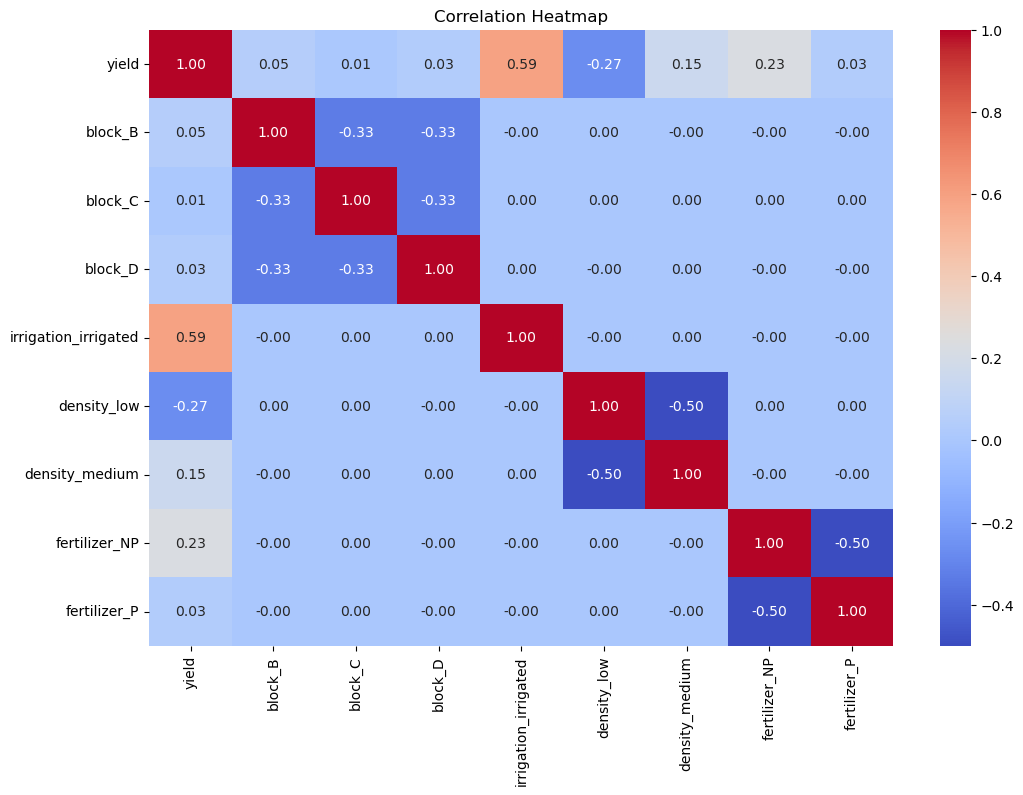

In [4]:
# Encoding categorical variables to numeric
encoded_df = pd.get_dummies(df, columns=['block', 'irrigation', 'density', 'fertilizer'], drop_first=True)

# Calculate the correlation matrix
correlation_matrix = encoded_df.corr()

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

### 1.2 Anova

In [5]:
# Perform ANOVA
groups = [group['yield'].values for _, group in df.groupby('fertilizer')]
anova_result = stats.f_oneway(*groups)

# Display results
print(f"ANOVA F-statistic: {anova_result.statistic:.2f}")
print(f"ANOVA p-value: {anova_result.pvalue:.4f}")

ANOVA F-statistic: 3.13
ANOVA p-value: 0.0499


**Interpretation:**

The p-value is just below 0.05, which is ussulaly the typical threshold for statistical significance. This suggests that there may be a statistically significant difference betwean the dependent varibable (**yield**) and the categorical variables. Meaning that we reject the null hypothesis and based on the context we can say that the type of fertilizer has an effect on the yield. However, because the p-value is close to the threshold we need to view our results with caution. 

In [6]:
# Perform ANOVA
groups_block = [group['yield'].values for _, group in df.groupby('block')]
anova_result_block = stats.f_oneway(*groups_block)

# Display results
print(f"ANOVA F-statistic: {anova_result_block.statistic:.2f}")
print(f"ANOVA p-value: {anova_result_block.pvalue:.4f}")

ANOVA F-statistic: 0.19
ANOVA p-value: 0.9049


In [7]:
# Perform ANOVA
groups_density = [group['yield'].values for _, group in df.groupby('density')]
anova_result_density = stats.f_oneway(*groups_density)

# Display results
print(f"ANOVA F-statistic: {anova_result_density.statistic:.2f}")
print(f"ANOVA p-value: {anova_result_density.pvalue:.4f}")

ANOVA F-statistic: 2.76
ANOVA p-value: 0.0704


In [8]:
# Perform ANOVA
groups_irrigation = [group['yield'].values for _, group in df.groupby('irrigation')]
anova_result_irrigation = stats.f_oneway(*groups_irrigation)

# Display results
print(f"ANOVA F-statistic: {anova_result_irrigation.statistic:.2f}")
print(f"ANOVA p-value: {anova_result_irrigation.pvalue:.4f}")

ANOVA F-statistic: 37.43
ANOVA p-value: 0.0000


## 1.3 Chi-Square Test

In [9]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Perform Chi-Square tests for all combinations of categorical variables
results = []
for var1, var2 in combinations(categorical_columns, 2):
    # Create a contingency table
    contingency_table = pd.crosstab(df[var1], df[var2])
    
    # Perform Chi-Square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    
    # Store results
    results.append({
        'Variable 1': var1,
        'Variable 2': var2,
        'Chi2 Statistic': chi2,
        'P-value': p,
        'Degrees of Freedom': dof
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display results
print("Pairwise Chi-Square Test Results:")
print(results_df)

Pairwise Chi-Square Test Results:
   Variable 1  Variable 2  Chi2 Statistic  P-value  Degrees of Freedom
0       block  irrigation             0.0      1.0                   3
1       block     density             0.0      1.0                   6
2       block  fertilizer             0.0      1.0                   6
3  irrigation     density             0.0      1.0                   2
4  irrigation  fertilizer             0.0      1.0                   2
5     density  fertilizer             0.0      1.0                   4


**Interpretation:**

For all pairs the Chi-Squared Statistic is 0.0 and the p-value 1.0 meaning that their is no evidence for any relationship between the categorical variables in this dataset. They seem indepentent of one another. 

## Finding the Best Model

In the following we fit a GLMM (Generalized Linear Mixed Model) for this dataset. A GLMM is well-suited for this dataset because it can handle both the fixed and random effects, as well as the mixture of categorical and continious data types. 

**Model Component**

Response variable: 

***yield*** (depentent variable, continious)

Fixed Effects: 

***fertilizer***: significant from the ANOVA, categorical variable

***density***:close to significant according to the ANOVA
(we explore the potential influnence it has on yield, might remove it later to improve the model)

***irrigation***: highly significant according to the ANOVA (a strong relationship with yield)

Random Effect:

***block***: has no significant effect on yield, however since the block may be experimental units, we include it as a random effect to account for any unexplained variability between the four different blocks. 

### Null Model

In [10]:
# Convert categorical variables to categories
for col in ['block', 'irrigation', 'density', 'fertilizer']:
    df[col] = df[col].astype('category')

# Rename the column 'yield' to 'yield_value'
data = df.rename(columns={'yield': 'yield_value'})

# Fit the GLMM
null_model = mixedlm("yield_value ~ irrigation + density + fertilizer", 
                data=data, 
                groups=data["block"])  # Random effect on 'block'
null_model_result = null_model.fit()

# Model Summary
print(null_model_result.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    yield_value
No. Observations:      72         Method:                REML       
No. Groups:            4          Scale:                 177.9255   
Min. group size:       18         Log-Likelihood:        -273.4760  
Max. group size:       18         Converged:             Yes        
Mean group size:       18.0                                         
--------------------------------------------------------------------
                         Coef.  Std.Err.   z    P>|z|  [0.025 0.975]
--------------------------------------------------------------------
Intercept                85.264    3.851 22.143 0.000  77.717 92.811
irrigation[T.irrigated]  21.444    3.144  6.821 0.000  15.282 27.607
density[T.low]          -10.042    3.851 -2.608 0.009 -17.589 -2.495
density[T.medium]         0.833    3.851  0.216 0.829  -6.714  8.380
fertilizer[T.NP]         12.750    3.851  3.311 0.

c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


*Note:*

*Explanation:*

- *Why the Error Happens: yield is a Python keyword (used in functions to return a generator), and patsy, the library used internally by statsmodels for formula parsing, throws an error when encountering reserved keywords.*
- *Solution: Renaming the column avoids this conflict.*

*Once you rename the column, everything else in your code remains unchanged. If you have additional steps or visualizations, ensure you use the updated column name (yield_value) consistently.*

**Interpretation:**

- Intercept:
    - Represents the expected yield-value for the baseline group (control irrigation, high density and N fertilizer)

- irrigation[T.irrigated]  21.444: 
    - irrigation increases the yield compared to the baseline
    - The coefficient is statistically significant 

- density[T.low]          -10.042: 
    - Low density decreases the yield
    - The coefficient is statistically significant 

- density[T.medium]         0.833:    
    - Medium density has no statistically significant effect on yield compared to high density

- fertilizer[T.NP]         12.750: 
    - NP fertilizer increases the yield
    - The effect is statistically significant

- fertilizer[T.P]           7.667:
    - P fertilizer increases the yield
    - The effect is marginally significant

- Group Var                 0.000: 
    - The variance of the random effect (block) is estimated to be 0.000, suggesting that block contributes no meaningful variability to yield_value after accounting for the fixed effects.

Key Takeways: 

1. Irrigation:
    - Significant and strong positive effect on yield. Switching from control to irrigated increases yield by ~21.44 units.
2. Density: 
    - Low density significantly reduces yield compared to high density, but medium density has no significant effect.
3. Fertilizer: 
    - NP fertilizer has the largest positive effect on yield (+12.75), followed by P fertilizer (+7.67), compared to N fertilizer.
4. Block:
    - block does not contribute significant random variability, suggesting little difference in yield across experimental blocks.

How can we simplify the model?

- Remove the block variable:  use a fixed effects model
- (treat density as a binary categorical variable (since medium density has no significant effect))


In [11]:
# Get AIC for the null model
print("AIC of Null Model:", null_model_result.aic)

AIC of Null Model: nan


### Model Reduction based on AIC

#### OLS 

Because I want to remove the random effect "block", using a Ordinary Least Squares (OLS) is better. We are left with only fixed effects and a OLS can handle these variables better than the GLMM 

In [12]:
import statsmodels.formula.api as smf

# Fit a simpler model without the block random effect (using OLS)
simpler_model_ols = smf.ols("yield_value ~ irrigation + density + fertilizer", data=data).fit()

# Model Summary
print(simpler_model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:            yield_value   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     13.50
Date:                Mon, 16 Dec 2024   Prob (F-statistic):           4.52e-09
Time:                        23:14:18   Log-Likelihood:                -285.56
No. Observations:                  72   AIC:                             583.1
Df Residuals:                      66   BIC:                             596.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [13]:
# Fit all models
simpler_model_ols_full = smf.ols("yield_value ~ irrigation + density + fertilizer", data=data).fit()
simpler_model_ols_no_density = smf.ols("yield_value ~ irrigation + fertilizer", data=data).fit()
simpler_model_ols_no_fertilizer = smf.ols("yield_value ~ irrigation + density", data=data).fit()
simpler_model_ols_no_irrigation = smf.ols("yield_value ~ density + fertilizer", data=data).fit()

# Print the AIC values
print("AIC for Full Model:", simpler_model_ols_full.aic)
print("AIC for Model without Density:", simpler_model_ols_no_density.aic)
print("AIC for Model without Fertilizer:", simpler_model_ols_no_fertilizer.aic)
print("AIC for Model without Irrigation:", simpler_model_ols_no_irrigation.aic)

AIC for Full Model: 583.1206061634791
AIC for Model without Density: 589.1669289426271
AIC for Model without Fertilizer: 590.325870730498
AIC for Model without Irrigation: 619.5325536845359


**Interpretation:**

The model with the the predictors irrigation, density and fertilizer has the lowest AIC. This suggests that this model is the most parsimonious model, as it provides the best balance between fit and complexity. 

#### GLM

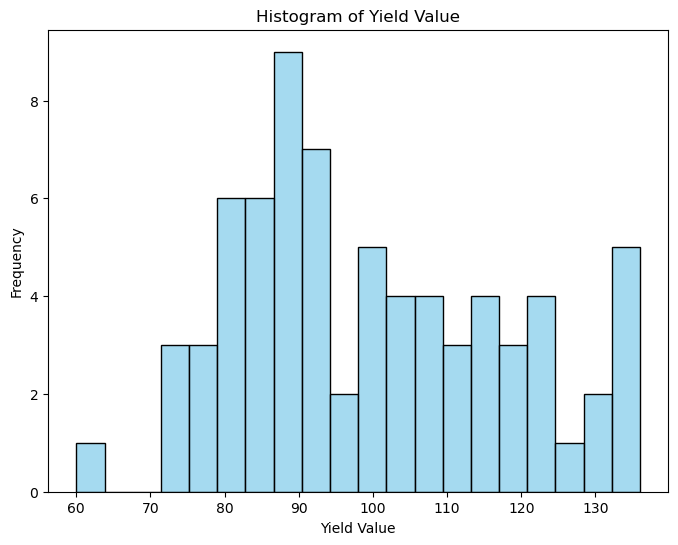

In [14]:
# Histogram
plt.figure(figsize=(8, 6))
sns.histplot(data['yield_value'], kde=False, bins=20, color='skyblue')
plt.title('Histogram of Yield Value')
plt.xlabel('Yield Value')
plt.ylabel('Frequency')
plt.show()

Data is not normally distrubited. 

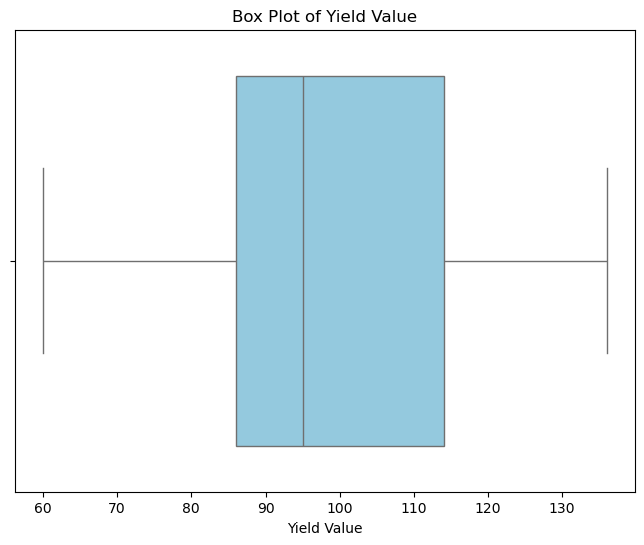

In [19]:
# Box Plot (to check for outliers)
plt.figure(figsize=(8, 6))
sns.boxplot(x=data['yield_value'], color='skyblue')
plt.title('Box Plot of Yield Value')
plt.xlabel('Yield Value')
plt.show()

In [21]:
from scipy.stats import shapiro, anderson, kstest
# Shapiro-Wilk Test for Normality
stat, p_value = shapiro(data['yield_value'])
print(f"Shapiro-Wilk Test: Stat={stat}, p-value={p_value}")

# If p-value > 0.05, data is normally distributed
if p_value > 0.05:
    print("Fail to reject the null hypothesis: Data is normally distributed.")
else:
    print("Reject the null hypothesis: Data is not normally distributed.")

# Anderson-Darling Test for Normality
result = anderson(data['yield_value'], dist='norm')
print(f"Anderson-Darling Test: Stat={result.statistic}")
for i in range(len(result.critical_values)):
    sl, cv = result.significance_level[i], result.critical_values[i]
    print(f"At {sl}% level, critical value is {cv}")
    if result.statistic < cv:
        print(f"Data is normally distributed at {sl}% level.")
    else:
        print(f"Data is not normally distributed at {sl}% level.")

# Kolmogorov-Smirnov Test for Normality
stat_ks, p_value_ks = kstest(data['yield_value'], 'norm')
print(f"Kolmogorov-Smirnov Test: Stat={stat_ks}, p-value={p_value_ks}")

# If p-value > 0.05, data is normally distributed
if p_value_ks > 0.05:
    print("Fail to reject the null hypothesis: Data is normally distributed.")
else:
    print("Reject the null hypothesis: Data is not normally distributed.")

Shapiro-Wilk Test: Stat=0.9586959371047564, p-value=0.0186607060755142
Reject the null hypothesis: Data is not normally distributed.
Anderson-Darling Test: Stat=1.022507481410912
At 15.0% level, critical value is 0.548
Data is not normally distributed at 15.0% level.
At 10.0% level, critical value is 0.624
Data is not normally distributed at 10.0% level.
At 5.0% level, critical value is 0.749
Data is not normally distributed at 5.0% level.
At 2.5% level, critical value is 0.874
Data is not normally distributed at 2.5% level.
At 1.0% level, critical value is 1.039
Data is normally distributed at 1.0% level.
Kolmogorov-Smirnov Test: Stat=1.0, p-value=0.0
Reject the null hypothesis: Data is not normally distributed.


### GLM

In [22]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.genmod.families import Gamma, Poisson, Gaussian
from statsmodels.genmod.families.links import Log, InversePower, Identity
import statsmodels.formula.api as smf

# Step 1: Split the data into train and test sets for model validation

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Step 2: Define a GLM model pipeline

def glm_pipeline(family, link_instance, formula):
    return smf.glm(formula=formula, data=train_data, family=family(link_instance)).fit()

# Step 3: Define the formula for the full model
full_formula = "yield_value ~ irrigation + density + fertilizer"

# Step 4: Fit models with different families and links (you can test different combinations)
# Instantiate the link functions
poisson_link = Log()  # For Poisson model
gamma_link = InversePower()  # For Gamma model
gaussian_link = Identity()  # For Gaussian model

# Step 5: Fit the full model
poisson_model = glm_pipeline(Poisson, poisson_link, full_formula)
gamma_model = glm_pipeline(Gamma, gamma_link, full_formula)
gaussian_model = glm_pipeline(Gaussian, gaussian_link, full_formula)

# Print AIC for full models
print("Poisson Model AIC:", poisson_model.aic)
print("Gamma Model AIC:", gamma_model.aic)
print("Gaussian Model AIC:", gaussian_model.aic)

# Step 6: Fit models after removing one variable at a time and compare AIC
# Remove 'irrigation'
formula_no_irrigation = "yield_value ~ density + fertilizer"
poisson_model_no_irrigation = glm_pipeline(Poisson, poisson_link, formula_no_irrigation)
gamma_model_no_irrigation = glm_pipeline(Gamma, gamma_link, formula_no_irrigation)
gaussian_model_no_irrigation = glm_pipeline(Gaussian, gaussian_link, formula_no_irrigation)

# Remove 'density'
formula_no_density = "yield_value ~ irrigation + fertilizer"
poisson_model_no_density = glm_pipeline(Poisson, poisson_link, formula_no_density)
gamma_model_no_density = glm_pipeline(Gamma, gamma_link, formula_no_density)
gaussian_model_no_density = glm_pipeline(Gaussian, gaussian_link, formula_no_density)

# Remove 'fertilizer'
formula_no_fertilizer = "yield_value ~ irrigation + density"
poisson_model_no_fertilizer = glm_pipeline(Poisson, poisson_link, formula_no_fertilizer)
gamma_model_no_fertilizer = glm_pipeline(Gamma, gamma_link, formula_no_fertilizer)
gaussian_model_no_fertilizer = glm_pipeline(Gaussian, gaussian_link, formula_no_fertilizer)

# Step 7: Compare AIC values
models = {
    "Poisson (Full)": poisson_model,
    "Gamma (Full)": gamma_model,
    "Gaussian (Full)": gaussian_model,
    "Poisson (No Irrigation)": poisson_model_no_irrigation,
    "Gamma (No Irrigation)": gamma_model_no_irrigation,
    "Gaussian (No Irrigation)": gaussian_model_no_irrigation,
    "Poisson (No Density)": poisson_model_no_density,
    "Gamma (No Density)": gamma_model_no_density,
    "Gaussian (No Density)": gaussian_model_no_density,
    "Poisson (No Fertilizer)": poisson_model_no_fertilizer,
    "Gamma (No Fertilizer)": gamma_model_no_fertilizer,
    "Gaussian (No Fertilizer)": gaussian_model_no_fertilizer
}

# Step 8: Find the model with the lowest AIC
best_model_name = min(models, key=lambda x: models[x].aic)
best_model = models[best_model_name]

print(f"\nThe best model is: {best_model_name} with AIC: {best_model.aic}")

# Step 9: Print the summary of the best model
print(best_model.summary())


Poisson Model AIC: 455.0123099142099
Gamma Model AIC: 451.7081061778736
Gaussian Model AIC: 454.70424218882135

The best model is: Gamma (Full) with AIC: 451.7081061778736
                 Generalized Linear Model Regression Results                  
Dep. Variable:            yield_value   No. Observations:                   57
Model:                            GLM   Df Residuals:                       51
Model Family:                   Gamma   Df Model:                            5
Link Function:           InversePower   Scale:                        0.014587
Method:                          IRLS   Log-Likelihood:                -219.85
Date:                Mon, 16 Dec 2024   Deviance:                      0.75368
Time:                        23:50:31   Pearson chi2:                    0.744
No. Iterations:                     6   Pseudo R-squ. (CS):             0.7120
Covariance Type:            nonrobust                                         
                              coef    

c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
c:\Users\Ellaine2\miniconda3\envs\env_analytics\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:308: DomainWarning: The InversePower link fu

#### Comparing OLS and GLM

**Interpretation**

The Gamma GLM has a much lower AIC compared to the OLS model, meaning is is more parsimonious. 



## Evaluating our best model

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

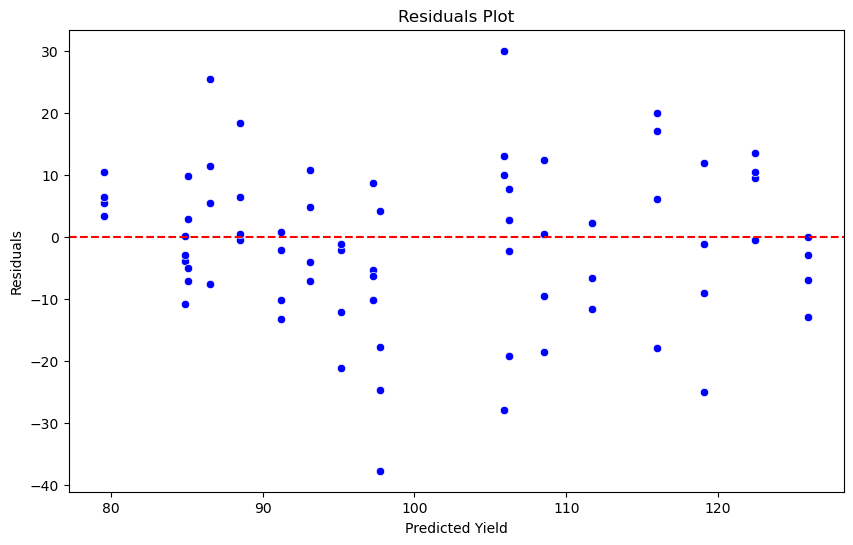

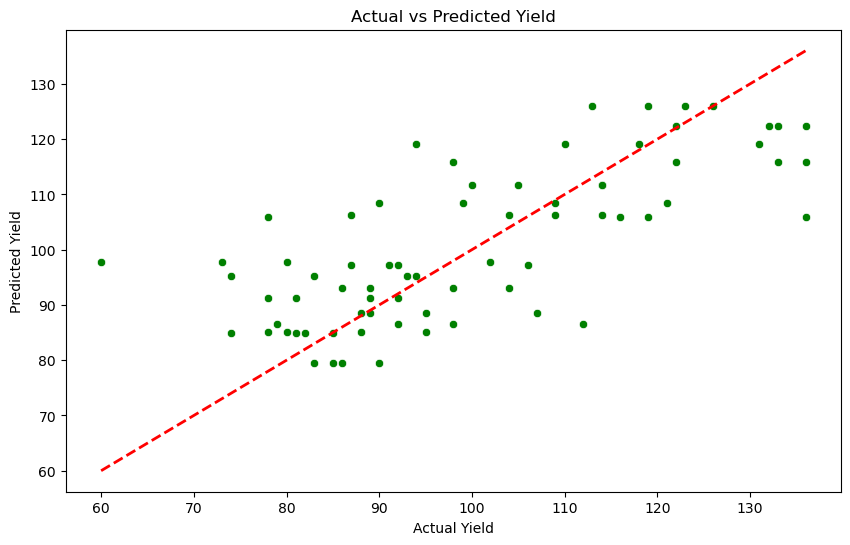

Evaluation Metrics:
Root Mean Squared Error (RMSE): 12.46
Mean Absolute Error (MAE): 9.61
R-squared (R²): 0.5293


In [25]:
# Predictions and Residuals
actual_values = data['yield_value']  # Actual target values
predicted_values = best_model.predict(data)  # Predicted target values
residuals = actual_values - predicted_values  # Residuals

# Plot Residuals
plt.figure(figsize=(10, 6))
sns.scatterplot(x=predicted_values, y=residuals, color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Yield")
plt.ylabel("Residuals")
plt.title("Residuals Plot")
plt.show()

# Plot Actual vs Predicted Values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=actual_values, y=predicted_values, color='green')
plt.plot([actual_values.min(), actual_values.max()], 
         [actual_values.min(), actual_values.max()], 'r--', lw=2)  # Diagonal line
plt.xlabel("Actual Yield")
plt.ylabel("Predicted Yield")
plt.title("Actual vs Predicted Yield")
plt.show()

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)
r2 = r2_score(actual_values, predicted_values)

print("Evaluation Metrics:")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-squared (R²): {r2:.4f}")

**Interpretation:**

- RMSE (12.46) and MAE (9.61) show that the predictions deviate moderately from the actual values.
- R² (0.5293) indicates the model explains about 53% of the variance, which is moderate but suggests there’s room for improvement.

While the Gamma GLM has the best AIC value, the evaluation metrics suggest that there is still room for improvement. 